<a href="https://colab.research.google.com/github/gnapat/CNN_Imageclassified/blob/Grad-CAM/deep_hw01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-634beae6-66a9-24e8-b04b-9affa0dc85bb)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

import cv2 as cv

#from tensorflow.keras.applications.vgg16 import preprocess_input

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
def to_array(X):
  images=[]
  for x in X:
    img_array = tf.keras.preprocessing.image.img_to_array(x)
    images.append(img_array)

  X_ret = np.array(images)

  return X_ret




def do_augmentation(img,y,aug):

  ret_x=[]
  ret_y=[]

  if aug == 1:
    aug_list = [Image.FLIP_LEFT_RIGHT]
  elif aug == 2:
    aug_list = [Image.ROTATE_180]
  elif aug == 3:
    #aug_list = [Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270]
    aug_list = [Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90]
  elif aug == 4:
    #aug_list = [Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270,Image.FLIP_LEFT_RIGHT,Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270]
    aug_list = [Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90,Image.FLIP_LEFT_RIGHT,Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90]



  ret_x.append(img)
  ret_y.append(y)

  #img = tf.keras.utils.array_to_img(img)

  for iaug in aug_list:
    img = img.transpose(method=iaug)
    #img_arr = tf.keras.preprocessing.image.img_to_array(img)
    ret_x.append(img)
    ret_y.append(y)



  return ret_x,ret_y

def load_dataset(xlist,ylist,aug=0):

  images = []
  labels = []

  cc = 0
  for f in xlist:
    img = tf.keras.preprocessing.image.load_img(f, target_size=(224, 224))

    if aug != 0:
      # do aug
      img_aug , y_aug = do_augmentation(img=img,y=ylist[cc],aug=aug)

      images.extend(img_aug)
      labels.extend(y_aug)
      #pass

    else:
      #img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.img_to_array(img)
      images.append(img)
      labels.append(ylist[cc])

    cc += 1

  return images,labels




def prepare_dataset(path,lables,test_size=0.2, random_state=42,split=True,augmentation=0,do_img_array=0):

  x = []
  y=[]
  x_path=[]
  images = []
  X_train = np.empty((244,244,3))
  X_test = np.array([])
  y_train = np.empty( (244,244,3))
  y_test =np.array([])

  for i in rock_label:
    folder_path=f"{path}/{rock_label[i]}"
    #print(folder_path)
    files = os.listdir(folder_path)
    for file in files:
      target_path = f"{folder_path}/{file}"
      #print(target_path)
      #img =  tf.keras.preprocessing.image.load_img(target_path, target_size=(224, 224))
      #img = tf.keras.preprocessing.image.img_to_array(img)
      #images.append(img)

      x_path.append(target_path)
      y.append(int(i))

  if split == True:
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(x_path, y, test_size=0.2, random_state=42)
    print(type(X_train_temp))
    X_train_temp, y_train_temp = load_dataset(X_train_temp,y_train_temp,augmentation)
    #print(type(X_train_temp))
    X_test_temp, y_test_temp = load_dataset(X_test_temp,y_test_temp,augmentation)

  if split == True:
    if do_img_array == 0:
      # return with image format
      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
    else:
      # return with nunpy array
      X_train_temp = to_array(X_train_temp)
      X_test_temp = to_array(X_test_temp)

      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
  else:
    return X,Y


In [4]:
path="drive/MyDrive/Gz/nida/dl/hw01/Rock"
rock_label={"1":"Amphibolite","2":"Andesite","3":"Basalt","4":"Carbonatite","4":"Coal"}
#rock_label={"1":"Amphibolite","2":"Andesite","3":"Basalt"}
#rock_label={"1":"Amphibolite"}

X_train,X_test,Y_train,Y_test = prepare_dataset(path=path,lables=rock_label,split=True,augmentation=4,do_img_array=1)

<class 'list'>


In [5]:
X_train.shape


(1016, 224, 224, 3)

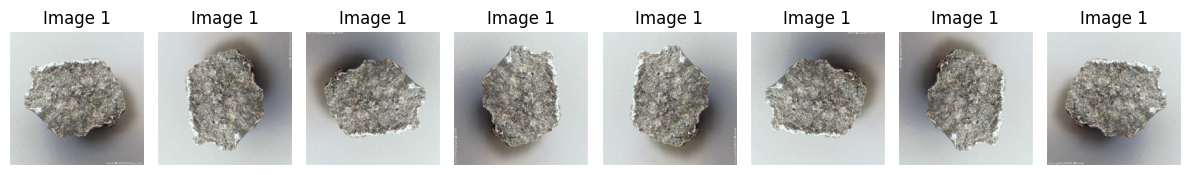

In [6]:
fig, axes = plt.subplots(1, 8, figsize=(12, 4))

for cc in range(8):
  axes[cc].imshow(tf.keras.preprocessing.image.array_to_img( X_train[cc+32]))
  axes[cc].set_title('Image 1')
  axes[cc].axis('off')



plt.tight_layout()
plt.show()

In [7]:
X_train.shape

(1016, 224, 224, 3)

In [8]:
img_w,img_h = 224,224     # image size of CIFAR-10
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
#tf.keras.utils.plot_model(vgg_extractor, to_file='cnn1_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [10]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(X_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(X_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (1016, 224, 224, 3) -123.68 151.061
float32 (256, 224, 224, 3) -123.68 151.061


In [11]:
vgg_extractor.trainable = False
for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


In [12]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

In [46]:
#tf.keras.utils.plot_model(model, to_file='vggoutput1.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [15]:
Y_train = np.array(Y_train)
history = model.fit( x_train_vgg, Y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )

Epoch 1/20
7/7 [==============================] - 44s 3s/step - loss: 43.2192 - acc: 0.3966 - val_loss: 15.2460 - val_acc: 0.5539
Epoch 2/20
7/7 [==============================] - 4s 546ms/step - loss: 14.3470 - acc: 0.7106 - val_loss: 15.0804 - val_acc: 0.5196
Epoch 3/20
7/7 [==============================] - 4s 568ms/step - loss: 4.7032 - acc: 0.8510 - val_loss: 9.4571 - val_acc: 0.5588
Epoch 4/20
7/7 [==============================] - 4s 633ms/step - loss: 1.0983 - acc: 0.9372 - val_loss: 10.7497 - val_acc: 0.5637
Epoch 5/20
7/7 [==============================] - 4s 634ms/step - loss: 0.4553 - acc: 0.9704 - val_loss: 10.4041 - val_acc: 0.6078
Epoch 6/20
7/7 [==============================] - 4s 566ms/step - loss: 0.2685 - acc: 0.9803 - val_loss: 10.6596 - val_acc: 0.6176
Epoch 7/20
7/7 [==============================] - 4s 563ms/step - loss: 0.2448 - acc: 0.9815 - val_loss: 10.8866 - val_acc: 0.6078
Epoch 8/20
7/7 [==============================] - 4s 553ms/step - loss: 0.0817 - acc

In [16]:
Y_test = np.array(Y_test)
results = model.evaluate(x_test_vgg, Y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

2/2 [==============================] - 1s 468ms/step - loss: 17.9060 - acc: 0.5156
['loss', 'acc']: [17.905956268310547, 0.515625]


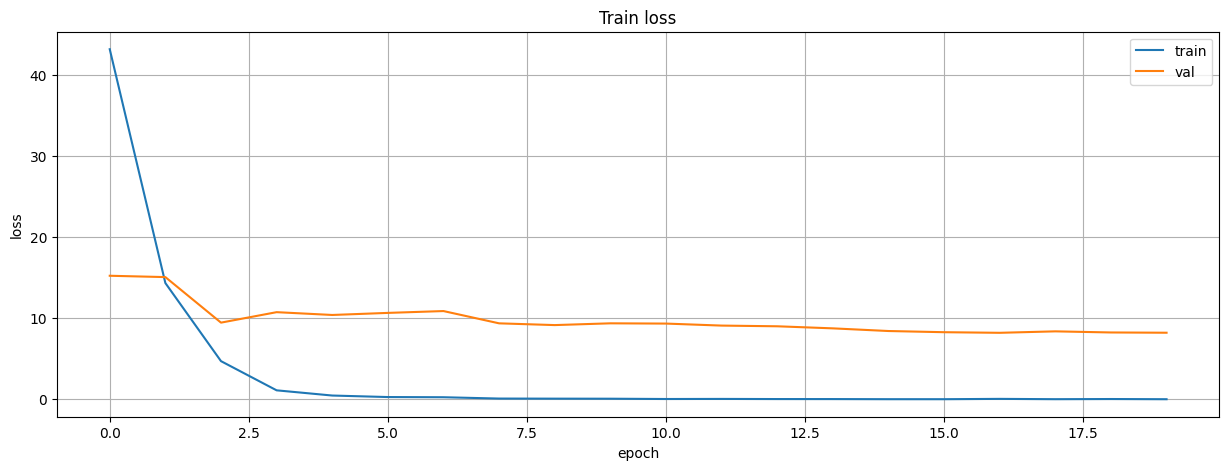

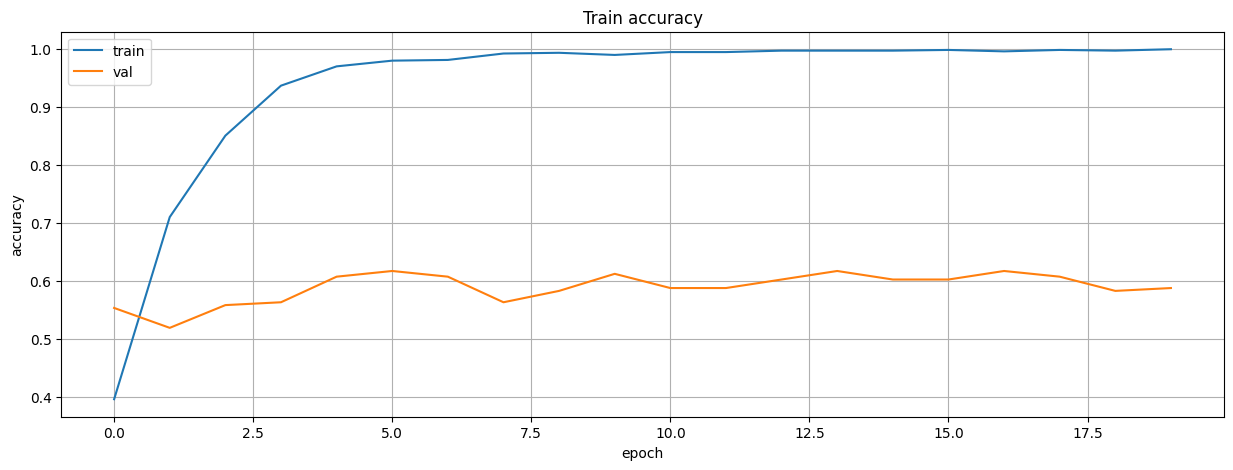

In [17]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

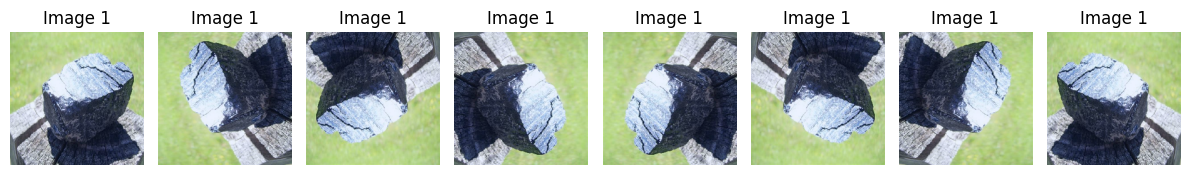

In [18]:
fig, axes = plt.subplots(1, 8, figsize=(12, 4))

for cc in range(8):
  axes[cc].imshow(tf.keras.preprocessing.image.array_to_img( X_test[cc+8]))
  axes[cc].set_title('Image 1')
  axes[cc].axis('off')



plt.tight_layout()
plt.show()

<class 'PIL.Image.Image'>


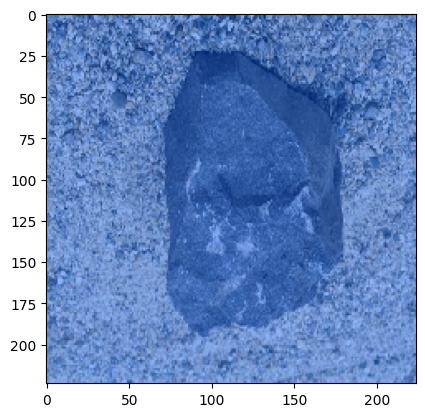

<class 'numpy.ndarray'>
type(x) = <class 'numpy.ndarray'> , x.dtype = float32 , x.shape = (1, 224, 224, 3) , min(x) = -1360.4801 , max(x) = -892.3291


In [41]:
img_preprocess1=tf.keras.preprocessing.image.array_to_img(X_train[2])
print(f"{type(img_preprocess1)}")
plt.imshow( img_preprocess1 )
plt.show()

img_preprocess1 = tf.keras.applications.vgg16.preprocess_input(np.expand_dims(X_train[2],axis=0))
print(f"{type(x)}")
print( f"type(x) = {type(img_preprocess1)} , x.dtype = {img_preprocess1.dtype} , x.shape = {img_preprocess1.shape} , min(x) = {np.min(img_preprocess1):.4f} , max(x) = {np.max(img_preprocess1):.4f}" )
#model.predict( tf.keras.applications.vgg16.preprocess_input(X_test))
#X_test[0]

In [26]:
img_preprocess1.shape

(1, 224, 224, 3)

In [47]:
print(f"{model.input_names} -> {model.output_names}")

['input_1'] -> ['dense_1']


In [29]:
pred = model.predict(img_preprocess1)
print(f"{pred.shape}")

# Decode the top 10 classes
#predictions = tf.keras.applications.vgg16.decode_predictions(pred, top=3)
#for i, prediction in enumerate(predictions):
#  print( f"Rank {i+1}: {prediction}" )

1/1 [==============================] - 0s 27ms/step
(1, 10)


ValueError: ignored

In [30]:
pred.shape

(1, 10)

In [48]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
    # 1. Get the output from the last convolutional layer
    last_conv_output = model.get_layer( last_conv_layer_name ).output

    # 2. Create the new model with one additional output
    new_model = tf.keras.Model( inputs=model.inputs, outputs=[model.output, last_conv_output] )

    return new_model

new_model = alter_model_for_GradCAM( model, 'block5_pool' )
new_model.summary()

print(f"{new_model.input_names} -> {new_model.output_names}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
def my_imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    Our adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    if len(preds.shape) != 2 or preds.shape[1] != 10:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        result.sort(key=lambda x: x[-1], reverse=True)
        results.append(result)

    return CLASS_INDEX, results

In [50]:
#img1 = tf.keras.preprocessing.image.img_to_array(X_test[0]).astype(np.uint8)
#img_preprocess1 = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(X_train[2], axis=0) )
print(f"{type(img_preprocess1)} {img_preprocess1.shape}")
out_linear1, _ = new_model.predict( img_preprocess1 )
print(f"{type(out_linear1)} ")
imagenet_dict, result1 = my_imagenet_decode_predictions( out_linear1, top=10 )

print( result1 )



<class 'numpy.ndarray'> (1, 224, 224, 3)
1/1 [==============================] - 0s 148ms/step
<class 'numpy.ndarray'> 
35363/35363 [==============================] - 0s 0us/step
[[(1, 'n01443537', 'goldfish', 1.0), (3, 'n01491361', 'tiger_shark', 4.3589225e-08), (9, 'n01518878', 'ostrich', 0.0), (8, 'n01514859', 'hen', 0.0), (7, 'n01514668', 'cock', 0.0), (6, 'n01498041', 'stingray', 0.0), (5, 'n01496331', 'electric_ray', 0.0), (4, 'n01494475', 'hammerhead', 0.0), (2, 'n01484850', 'great_white_shark', 0.0), (0, 'n01440764', 'tench', 0.0)]]


 Grad-CAM for CNN

In [56]:
import cv2 as cv

def my_CNN_GradCAM( model, in_img, class_index, normalize=True ):
  '''
  A function to compute a GradCAM heatmap image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    in_img (NumPy array): an image to be inspected
    class_index (int, 0-999): an ImageNet's class index that we want to inspect its GradCAM heatmap
    normalize (bool): if True, normalize the resultant heatmap to [0,1]

  Outputs:
    An image of GradCAM heatmap
  '''
  # Convert from numpy to tensor
  in_img = tf.cast( in_img, tf.float32 )

  # Compute the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_linear, last_conv_activation = model( in_img )
    one_class_score = y_linear[ ..., class_index ]
  gradient = tape.gradient( one_class_score, last_conv_activation )  # tensor: shape=(1,7,7,512)

  # Compute a vector of alphas by averaging each 2D gradient
  # Note that, one alpha value refers to a single weight value for a 2D feature map
  gradient = gradient.numpy().squeeze(axis=0)    # numpy: shape=(7,7,512)
  alpha = np.mean( gradient, axis=(0,1) )   # numpy: shape=(512,)

  # Compute the weighted-sum heatmap
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)   # numpy: shape (1,7,7,512) => (7,7,512)
  heatmap = np.dot( last_conv_activation, alpha )   # numpy: shape=(7,7)

  # Don't highlight any pixels with negative gradients (= apply ReLU)
  heatmap = np.maximum( 0, heatmap )     # numpy: shape=(7,7)

  # Return the heatmap
  return heatmap / np.max(heatmap) if normalize else heatmap

Test visualizing Grad-CAM for ImageNet classes with the 20 highest prediction scores

In [57]:
def visualize_GradCAM_topresult( model, original_img, input_img, logit_preds, top=100, heatmap_norm=True):
  '''
  A utility function that helps visualize the GradCAM results on top of the input image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    original_img (Numpy): an input image to be visualized
    input_img (Numpy): a preprocessed image to be fed to the model
    logit_preds (Numpy): an array of 1000 raw prediction scores (logits, non-softmax scores) regarding the 'input_img'
    top (int): how many class with top prediciton scores will be visualized
    heatmap_norm (bool): if True, normalize the heatmap to [0,1]
  '''
  # Get predictions with highest scores
  _ , top_results = my_imagenet_decode_predictions( logit_preds, top=top )

  # Extract 0-based class indices
  top_index = [ tp[0] for tp in top_results[0] ]

  # Visualize Grad-CAM for each class whose index is in 'top_index'
  for i,c in enumerate(top_index):
    heatmap = my_CNN_GradCAM(  model,         # the CNN model
                               input_img,     # input of the model
                               c,             # the 0-based index of the output class to compute and visualize GradCAM
                               heatmap_norm
                           )

    # Create the main figure
    fig = plt.figure(figsize=(15,5))
    class_desc = f"{imagenet_dict[c][-1]}, Top {i+1}/{top} with a logit score of {logit_preds[...,c].squeeze():.4f}"
    class_desc += f", normalized" if heatmap_norm else f", unnormalized"
    fig.suptitle( f"ImageNet class no. {c}/{len(imagenet_dict)-1} ({class_desc})" )

    # Subplot 1
    # Visualize the original heatmap
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title( "Original Grad-CAM" )
    im = ax.imshow( heatmap, cmap='jet' )
    plt.colorbar( im, ax=ax )

    # Subplot 2
    # Visualize the heatmap overlaid on an input image
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title( "Resized Grad-CAM on an input image" )
    ax.imshow( original_img )
    alpha = 0.6
    im = ax.imshow( cv.resize( heatmap, original_img.shape[:2] ), cmap='jet', alpha=alpha )
    plt.colorbar( im, ax=ax )

    # Show this figure
    plt.show()

In [54]:
X_train[2].shape

(224, 224, 3)

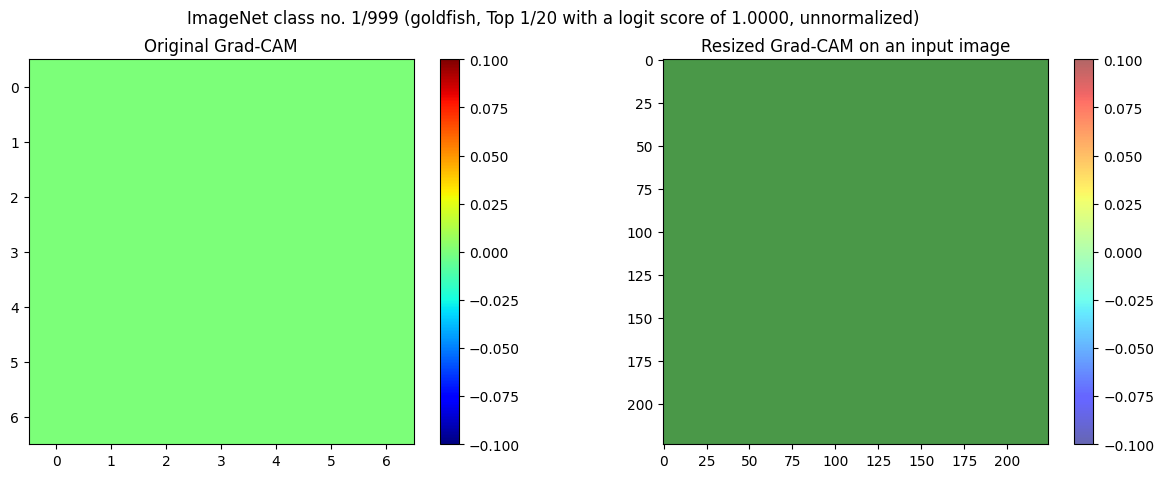

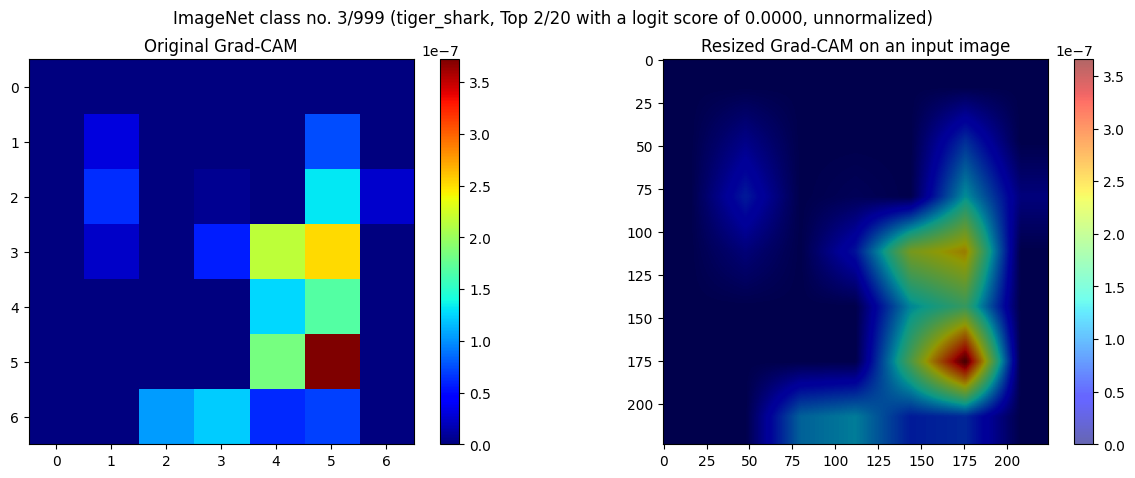

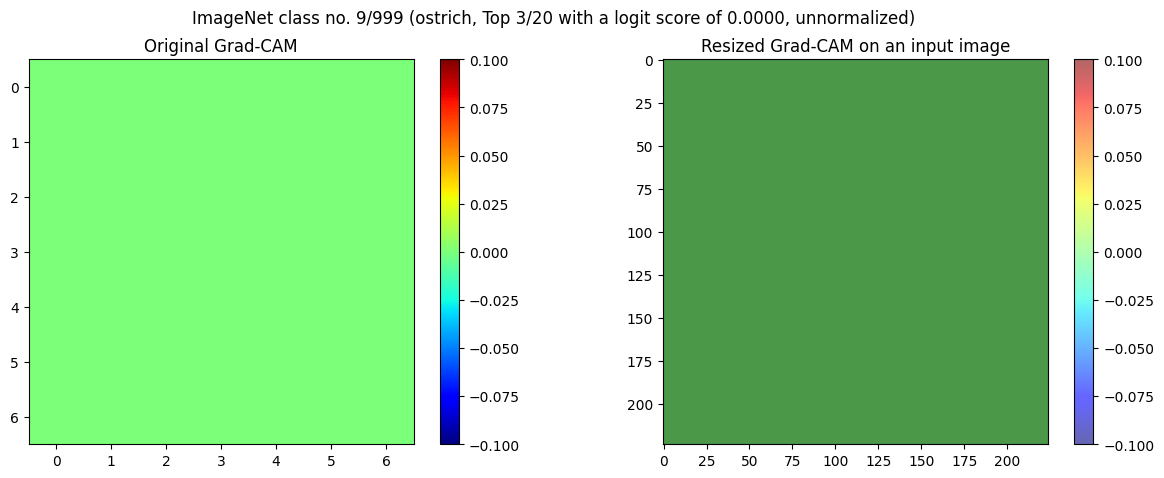

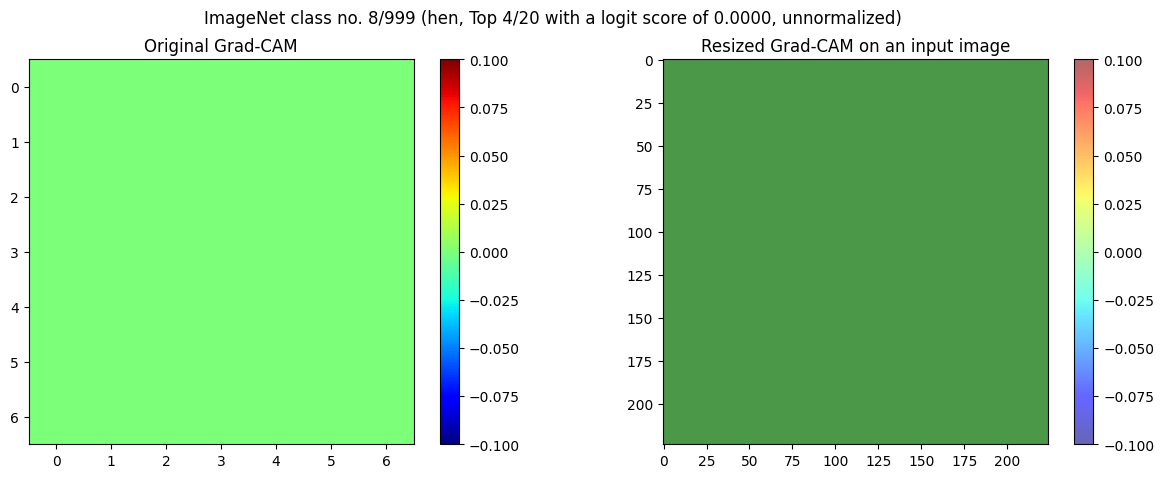

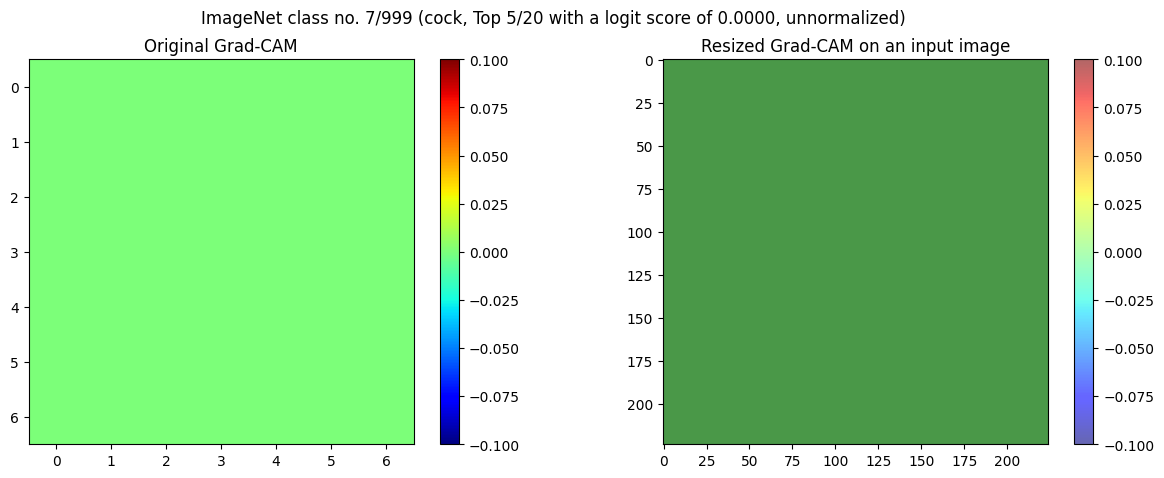

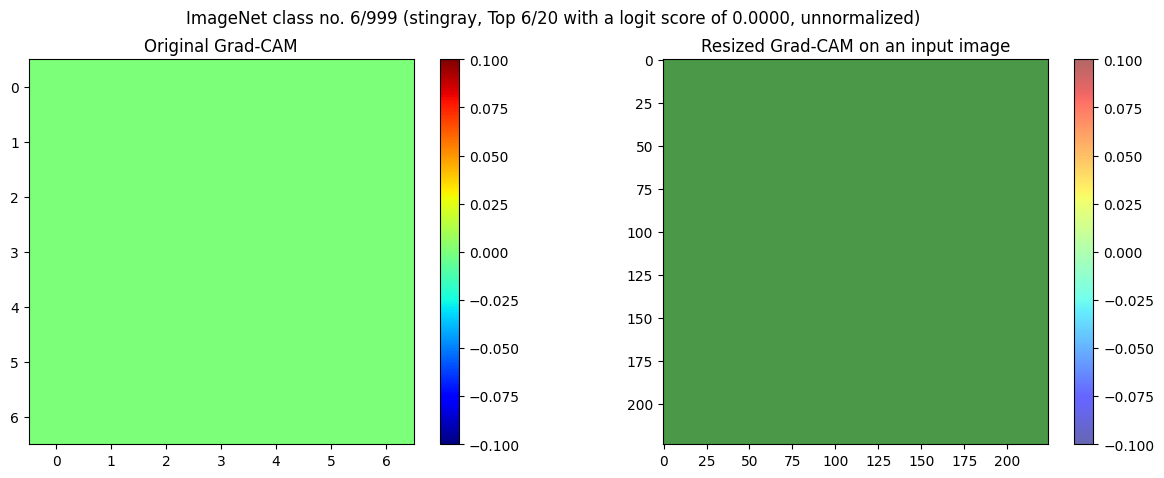

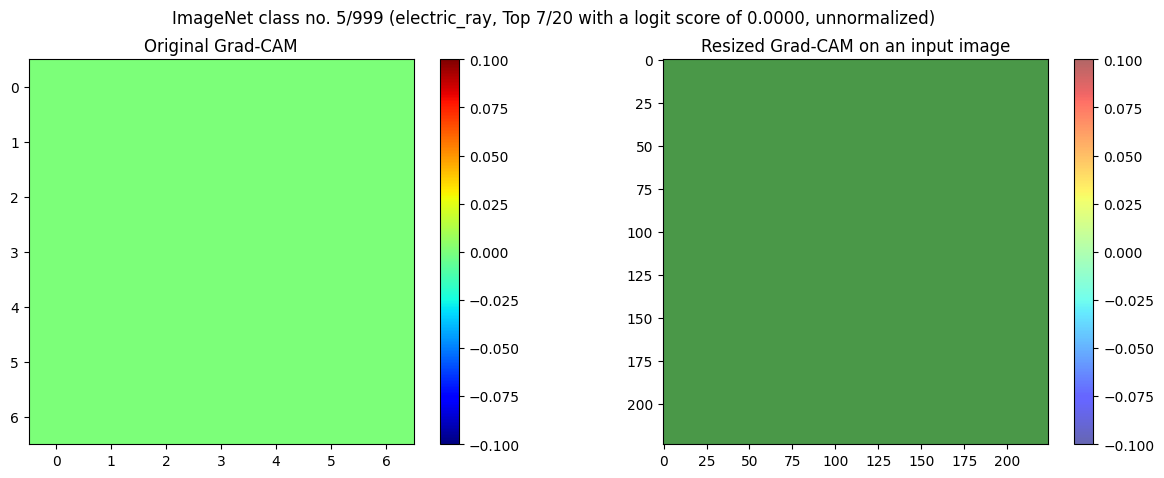

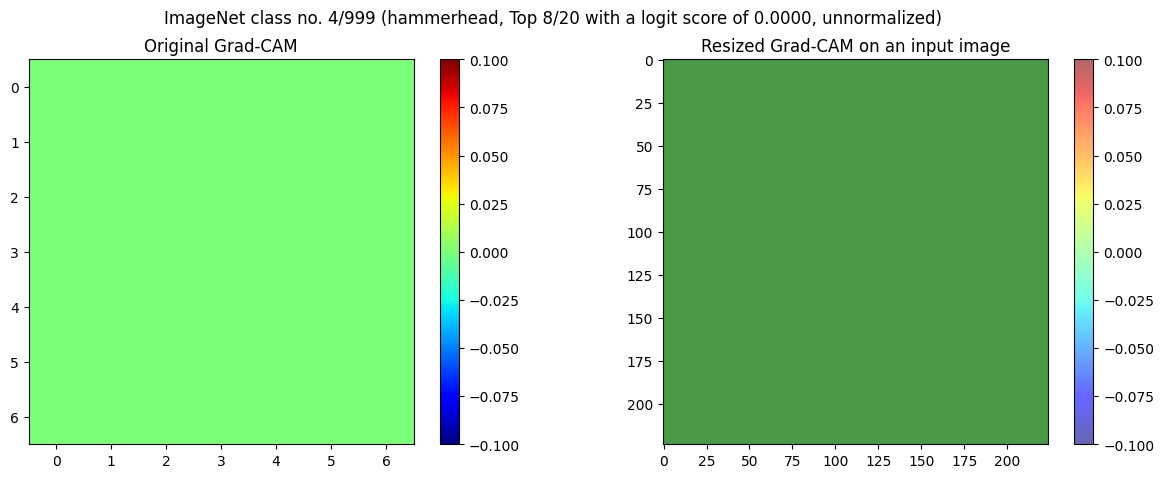

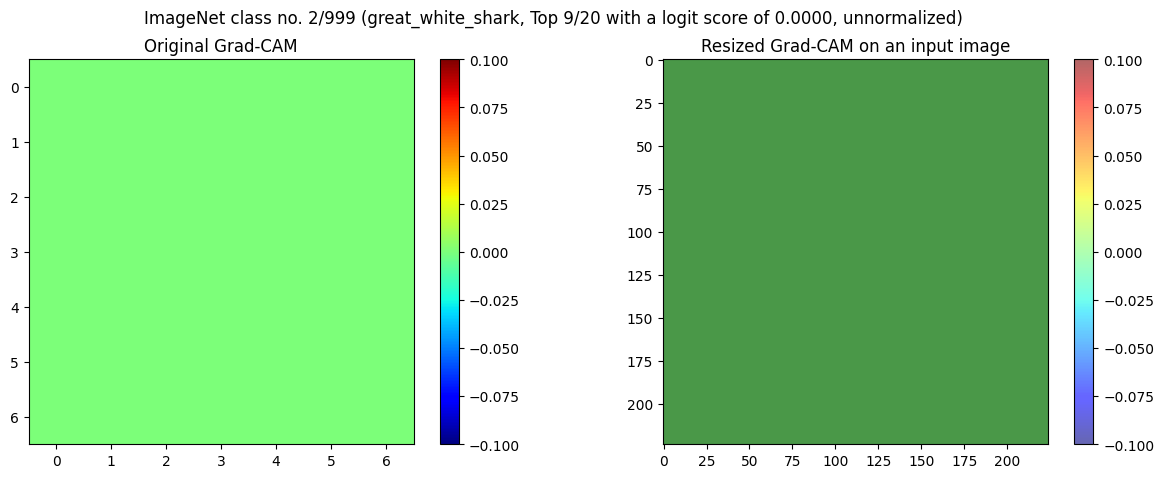

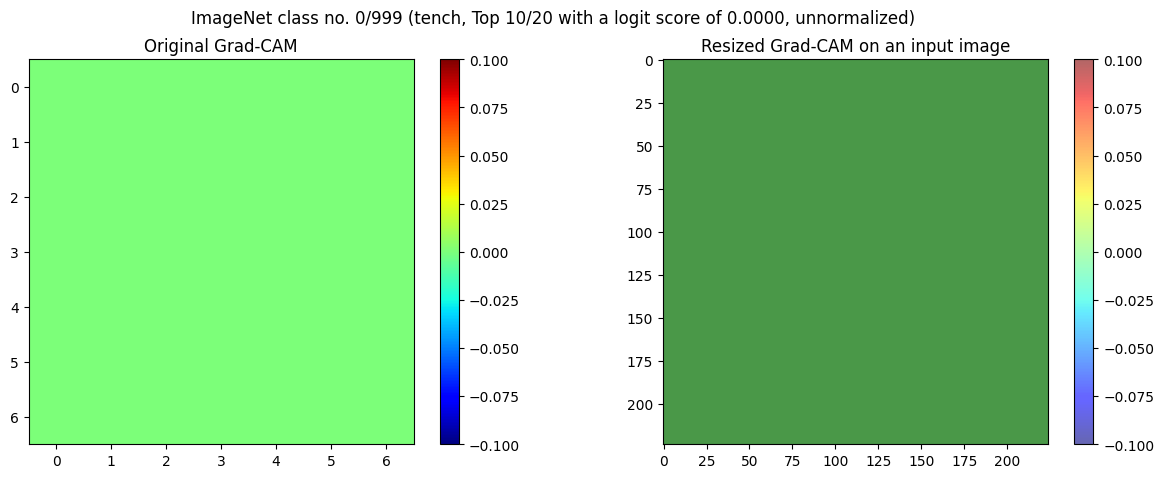

In [58]:
visualize_GradCAM_topresult( new_model, X_train[2], img_preprocess1, out_linear1, top=20, heatmap_norm=False)